In [2]:
import torch

In [3]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda Tesla T4


#Generate data

In [4]:
import random
lstX = []
lstY = []
for x in range(-100, 100, 5):
  lstX.append([x])
  y = 3*x + random.uniform(0, 1)*100
  lstY.append([y])

In [5]:
import numpy as np
numpyX = np.array(lstX)
numpyY = np.array(lstY)
print(numpyX.shape, numpyY.shape)

(40, 1) (40, 1)


In [6]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY_hat, testY_hat = train_test_split(numpyX, numpyY, test_size=0.20, random_state=0)
print(trainX.shape, testX.shape, trainY_hat.shape, testY_hat.shape)

(32, 1) (8, 1) (32, 1) (8, 1)


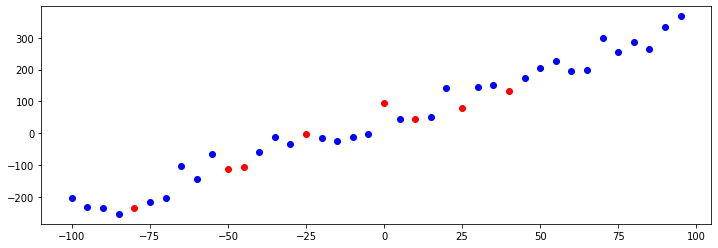

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.scatter(trainX, trainY_hat, color = "blue")
plt.scatter(testX, testY_hat, color = "red")
plt.show()

# Build NN with dropout

In [8]:
import torch.nn as nn

In [9]:
MyNet = nn.Sequential(
    nn.Linear(1, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 1),
)
MyNet.to(device)
print(MyNet)

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=50, bias=True)
  (3): ReLU()
  (4): Linear(in_features=50, out_features=1, bias=True)
)


In [15]:
from torchsummary import summary
summary(MyNet, input_size=(10, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 10, 100]             200
              ReLU-2              [-1, 10, 100]               0
            Linear-3               [-1, 10, 50]           5,050
              ReLU-4               [-1, 10, 50]               0
            Linear-5                [-1, 10, 1]              51
Total params: 5,301
Trainable params: 5,301
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.02
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [16]:
loss_func = torch.nn.MSELoss()

In [17]:
optimizer = torch.optim.Adam(MyNet.parameters(), lr=0.005)

#practice drop out

In [18]:
tensorX = torch.FloatTensor(trainX).to(device)
tensorY_hat = torch.FloatTensor(trainY_hat).to(device)

In [34]:
dropout25 = nn.Dropout(0.9)

In [37]:
L1out = MyNet[0](tensorX)
print(L1out)

tensor([[ -4.2605,   3.7367,  -5.8937,  ...,  10.2985,  -9.5970,  -2.7481],
        [ 26.6907,   1.4253,  35.8843,  ..., -43.0575,  41.3264,  -8.8071],
        [ 21.0632,   1.8456,  28.2883,  ..., -33.3564,  32.0676,  -7.7055],
        ...,
        [ 52.0145,  -0.4658,  70.0664,  ..., -86.7124,  82.9910, -13.7644],
        [-46.4667,   6.8886, -62.8638,  ...,  83.0567, -79.0381,   5.5141],
        [-54.9079,   7.5190, -74.2578,  ...,  97.6083, -92.9263,   7.1665]],
       device='cuda:0', grad_fn=<AddmmBackward>)


In [38]:
L1out = dropout25(L1out)
L1out

tensor([[ -42.6049,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
            0.0000],
        [   0.0000,   14.2531,    0.0000,  ..., -430.5751,    0.0000,
            0.0000],
        [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
            0.0000],
        ...,
        [   0.0000,    0.0000,    0.0000,  ...,    0.0000,  829.9104,
            0.0000],
        [-464.6669,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
            0.0000],
        [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
            0.0000]], device='cuda:0', grad_fn=<FusedDropoutBackward>)

# Train N epoches

In [20]:
lossLst = []
for epoch in range(1, 500):
    tensorX.dropout = nn.Dropout(0.25)
    tensorY = MyNet(tensorX)
    loss = loss_func(tensorY_hat, tensorY)
    loss1 = float(loss)
    #print("%.2f" % (loss1), end = ", ")
    lossLst.append(loss1)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

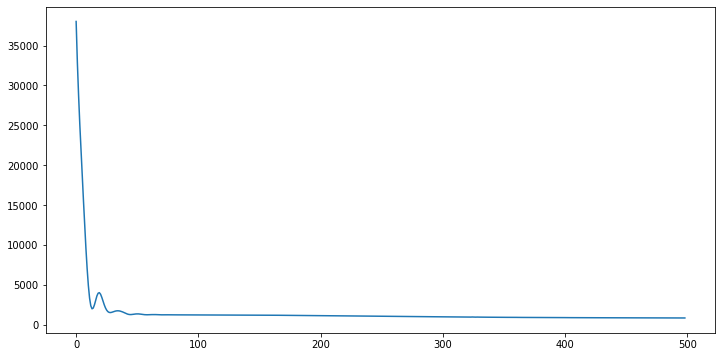

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(lossLst)
plt.show()

##Training data performance

In [ ]:
tensorY = MyNet(tensorX)
loss = loss_func(tensorY, tensorY_hat)
print("%.2f" % (float(loss)))

612.99


In [ ]:
trainY = tensorY.detach().cpu().numpy()

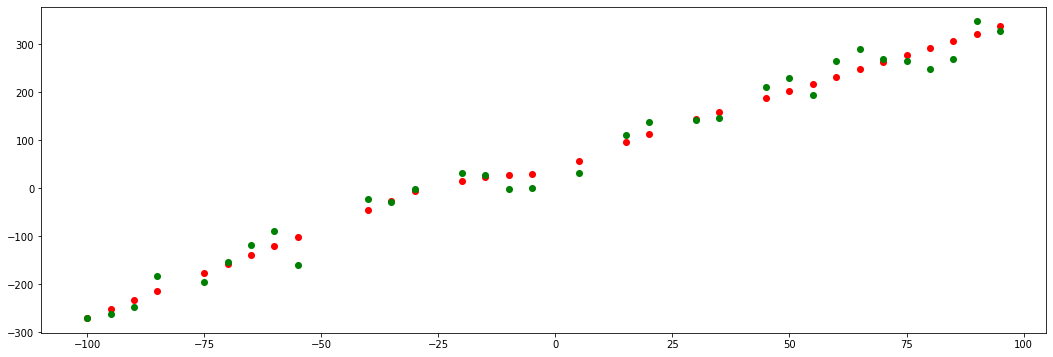

In [ ]:
plt.figure(figsize=(18, 6))
plt.scatter(trainX, trainY, s=50, lw=0, color="red")
plt.scatter(trainX, trainY_hat, s=50, lw=0, color="green")
plt.show()

# Test 

In [ ]:
tensorX = torch.FloatTensor(testX).to(device)
tensorY_hat = torch.FloatTensor(testY_hat).to(device)
tensorY = MyNet(tensorX)
loss = loss_func(tensorY, tensorY_hat)
print("%.2f" % (float(loss)))

1701.62


In [ ]:
testY = tensorY.detach().cpu().numpy()

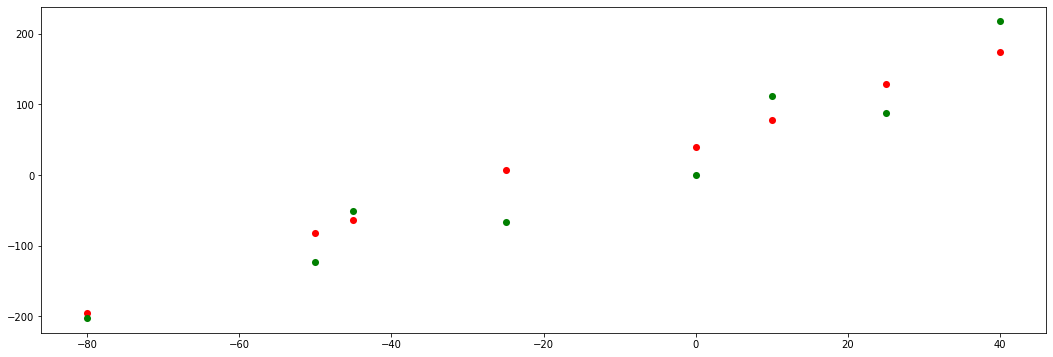

In [ ]:
plt.figure(figsize=(18, 6))
plt.scatter(testX, testY, s=50, lw=0, color="red")
plt.scatter(testX, testY_hat, s=50, lw=0, color="green")
plt.show()